## Modélisation prédictive des prix des cryptomonnaies

####  1.Préparation de l'environnement et chargement des données :

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error


In [130]:
crypto_df = pd.read_csv('Crypto.csv')
crypto_df.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %,Crypto,Date_FR,Month,Year
0,0,2025-03-16,2.3005,2.3882,2.4093,2.2699,375930000.0,-3.79%,XRP,2025-03-16,3,2025
1,1,2025-03-15,2.3912,2.3553,2.4733,2.3544,413810000.0,1.53%,XRP,2025-03-15,3,2025
2,2,2025-03-14,2.3551,2.2441,2.3883,2.2385,537830000.0,4.57%,XRP,2025-03-14,3,2025
3,3,2025-03-13,2.2522,2.2388,2.3448,2.2154,717080000.0,0.58%,XRP,2025-03-13,3,2025
4,4,2025-03-12,2.2391,2.1724,2.2614,2.1365,740780000.0,3.19%,XRP,2025-03-12,3,2025


In [131]:
Crypto_df = crypto_df.drop(columns=['Unnamed: 0'])

In [132]:
Crypto_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Crypto,Date_FR,Month,Year
0,2025-03-16,2.3005,2.3882,2.4093,2.2699,375930000.0,-3.79%,XRP,2025-03-16,3,2025
1,2025-03-15,2.3912,2.3553,2.4733,2.3544,413810000.0,1.53%,XRP,2025-03-15,3,2025
2,2025-03-14,2.3551,2.2441,2.3883,2.2385,537830000.0,4.57%,XRP,2025-03-14,3,2025
3,2025-03-13,2.2522,2.2388,2.3448,2.2154,717080000.0,0.58%,XRP,2025-03-13,3,2025
4,2025-03-12,2.2391,2.1724,2.2614,2.1365,740780000.0,3.19%,XRP,2025-03-12,3,2025


In [133]:
# Conversion en date
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])
crypto_df.sort_values(by='Date', inplace=True)

#varuiables supplémentaires pour rf 
crypto_df['Year'] = crypto_df['Date'].dt.year
crypto_df['Month'] = crypto_df['Date'].dt.month
crypto_df['Day'] = crypto_df['Date'].dt.day
cryptos = ['BTC', 'ETH', 'SOL', 'XRP']


#### Création d'un ensemble de données d'entraînement et de test

In [134]:
def train_test_split(df, ratio=0.8):
    split = int(len(df)*ratio)
    return df.iloc[:split], df.iloc[split:]

#### Modèle Prophet : Modèle conçu pour gérer clairement les composantes cycliques et saisonnières.

03:06:25 - cmdstanpy - INFO - Chain [1] start processing
03:06:26 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x700 with 0 Axes>

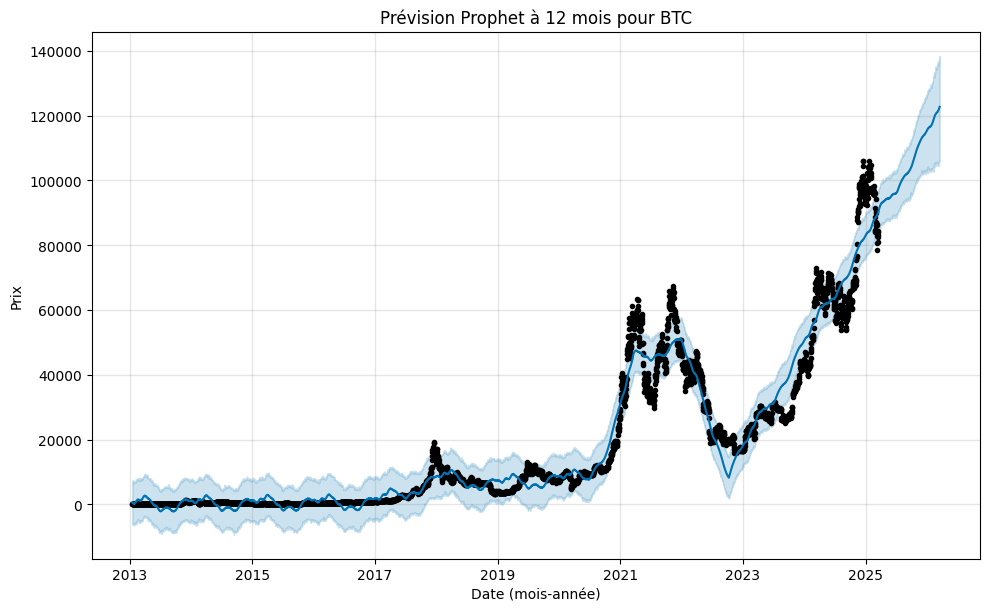

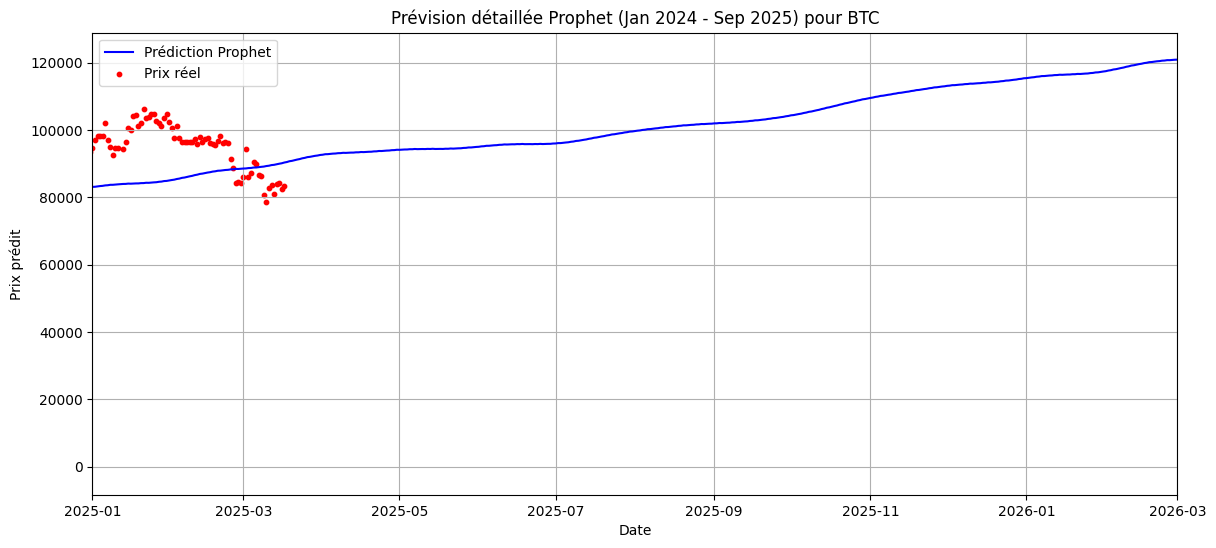

Crypto: BTC | MSE Prophet: 25394284.54


03:06:28 - cmdstanpy - INFO - Chain [1] start processing
03:06:29 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x700 with 0 Axes>

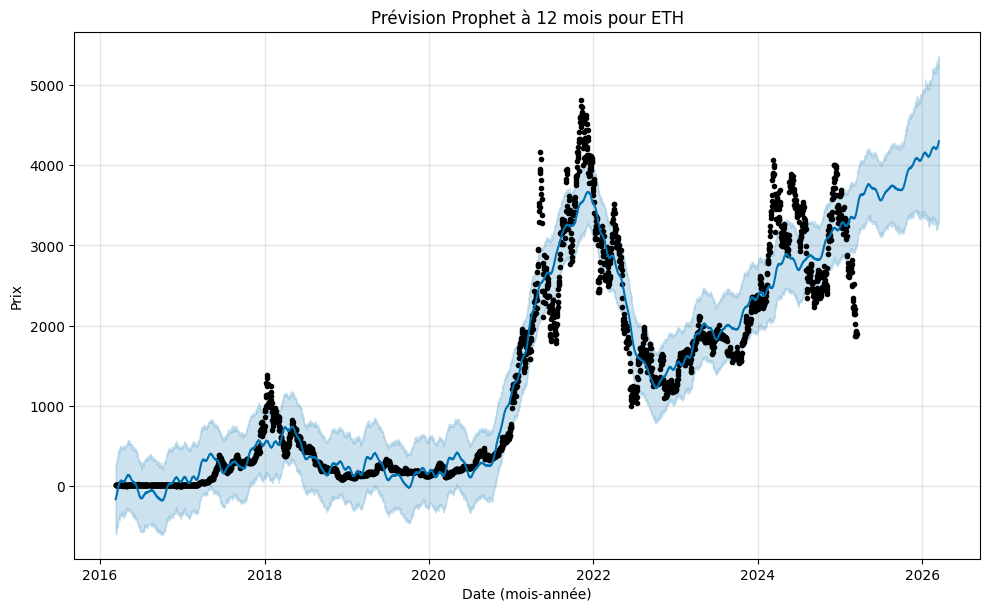

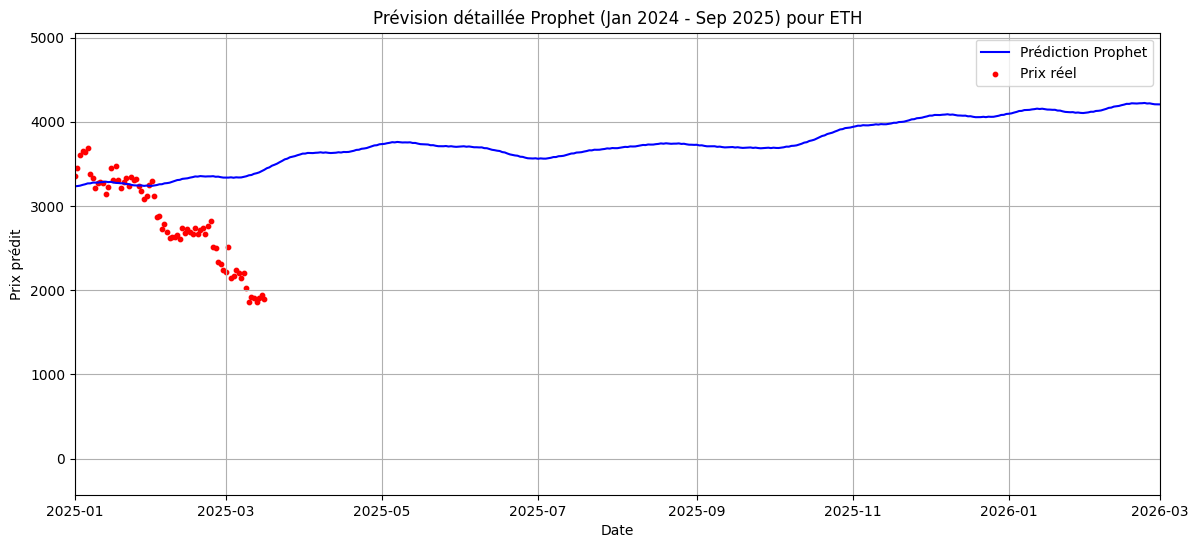

Crypto: ETH | MSE Prophet: 107163.58


03:06:30 - cmdstanpy - INFO - Chain [1] start processing
03:06:30 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x700 with 0 Axes>

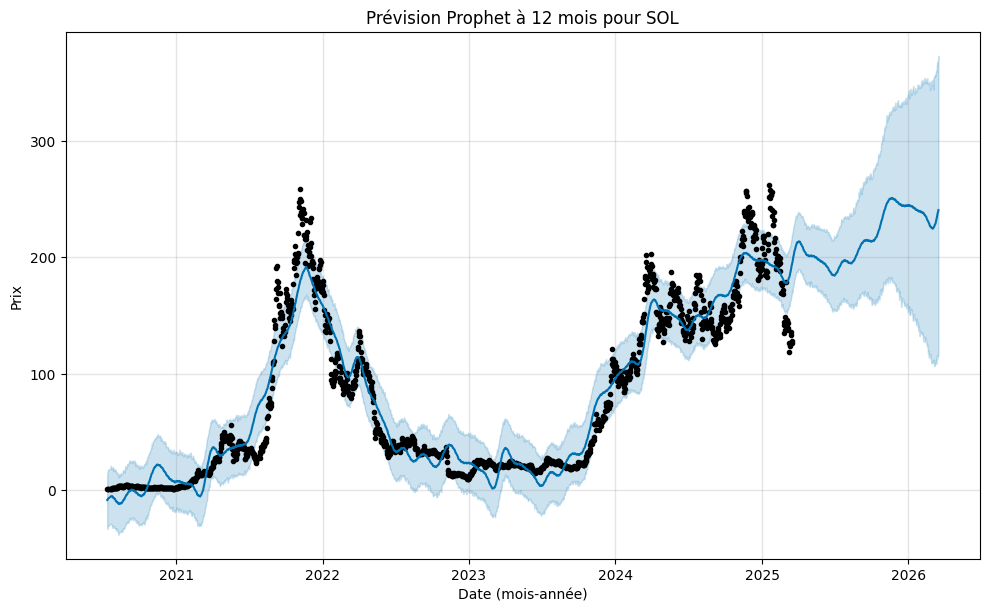

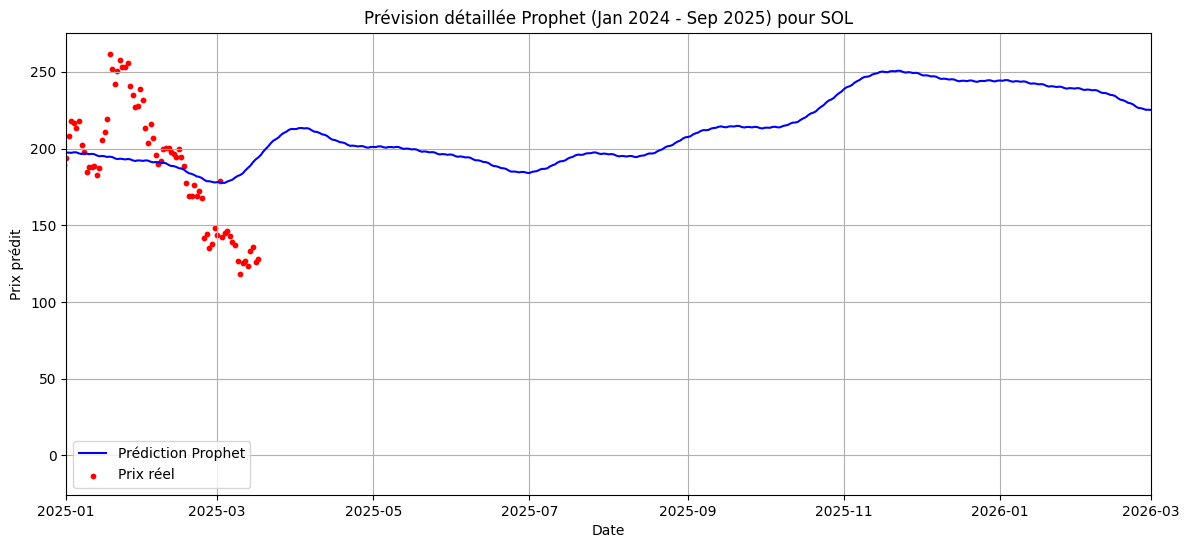

Crypto: SOL | MSE Prophet: 367.07


03:06:32 - cmdstanpy - INFO - Chain [1] start processing
03:06:32 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x700 with 0 Axes>

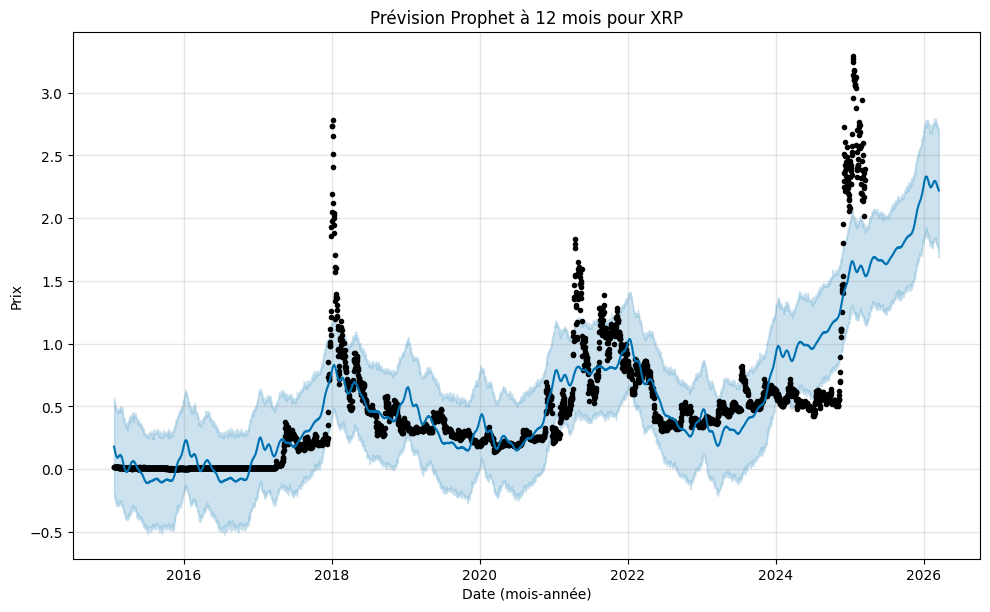

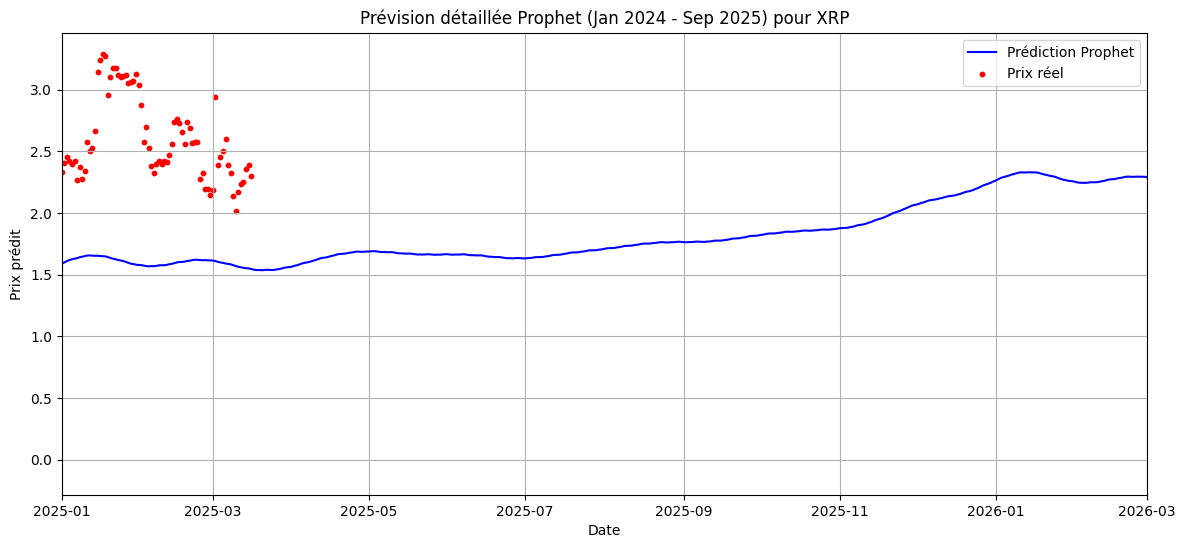

Crypto: XRP | MSE Prophet: 0.08


In [171]:
mse_prophet = {}
for crypto in cryptos:
    df = crypto_df[crypto_df['Crypto'] == crypto].copy()

    # Préparation des données pour Prophet
    prophet_df = df[['Date', 'Price']].rename(columns={'Date':'ds', 'Price':'y'})

    # Entrainement du modèle
    model_prophet = Prophet()
    model_prophet.fit(prophet_df)

    # Prévision dans le futur (12 mois)
    future = model_prophet.make_future_dataframe(periods=365)
    forecast = model_prophet.predict(future)

    # Affichage clair des résultats
    plt.figure(figsize=(14,7))
    model_prophet.plot(forecast)
    plt.title(f'Prévision Prophet à 12 mois pour {crypto}')
    plt.xlabel('Date (mois-année)')
    plt.ylabel('Prix')
    plt.grid(True)
    plt.show()

    # Zoom précis sur la période de janvier 2024 à septembre 2025
    plt.figure(figsize=(14,6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Prédiction Prophet', color='blue')
    plt.scatter(df['Date'], df['Price'], color='red', label='Prix réel', s=10)
    plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2026-03-01'))
    plt.title(f'Prévision détaillée Prophet (Jan 2024 - Sep 2025) pour {crypto}')
    plt.xlabel('Date')
    plt.ylabel('Prix prédit')
    plt.grid(True)
    plt.legend()
    plt.show()
    # Évaluation avec MSE
    mse = mean_squared_error(df['Price'], forecast['yhat'][:len(df)])
    mse_prophet[crypto] = mse
    print(f'Crypto: {crypto} | MSE Prophet: {mse:.2f}')

#### Model Randomforest  : pour utiliser des  variables explicatives supplémentaires comme le volume ou le prix du BTC.

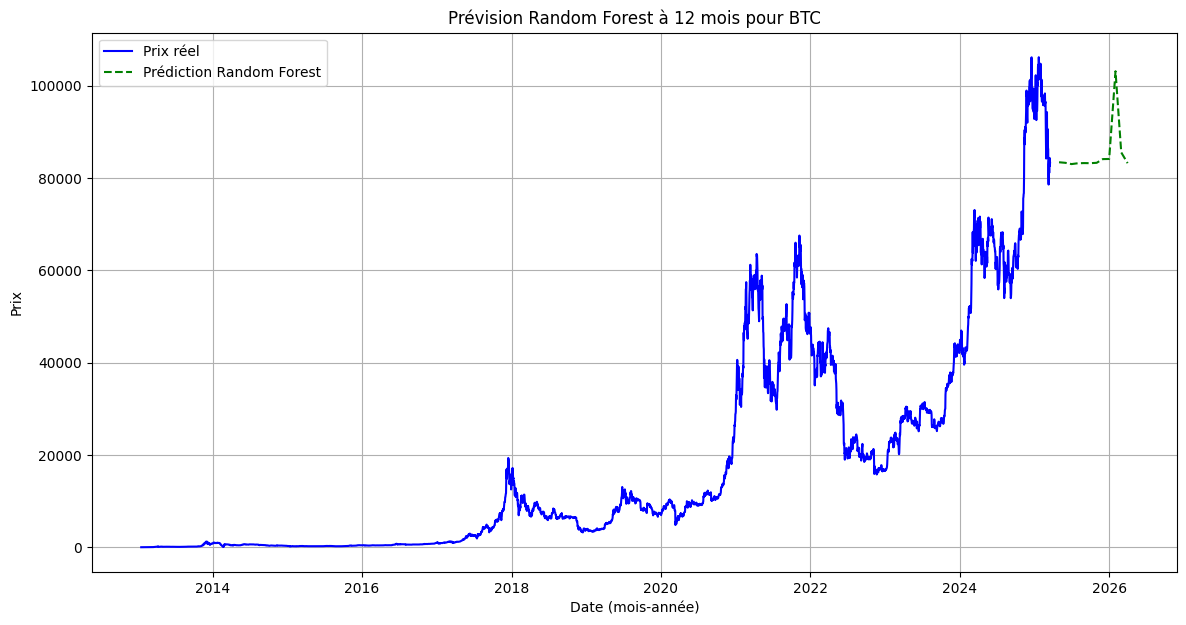

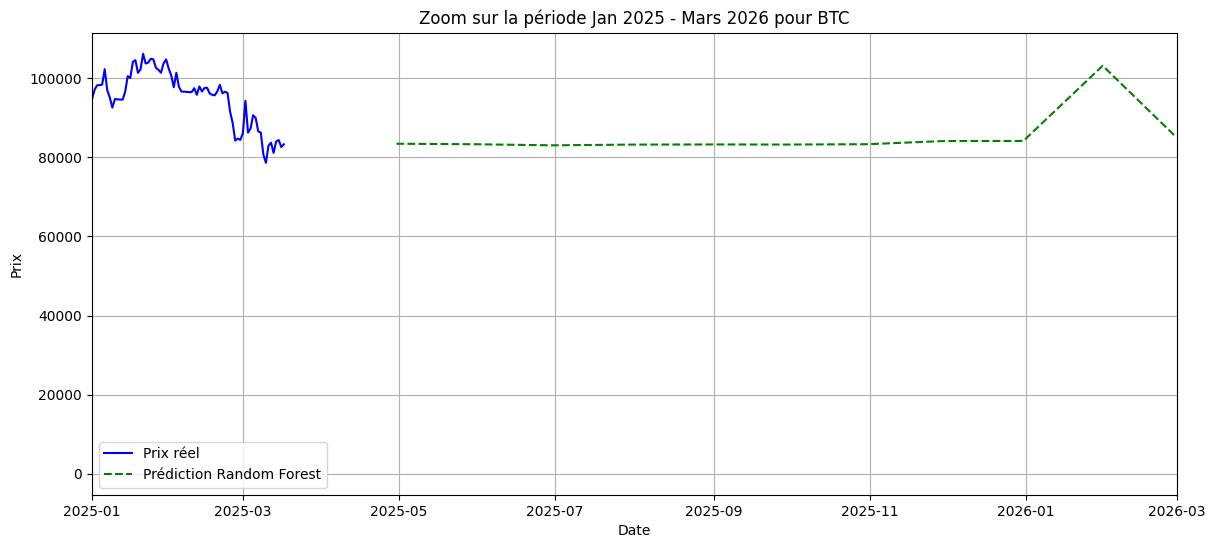

Crypto: BTC | MSE: 148534.37


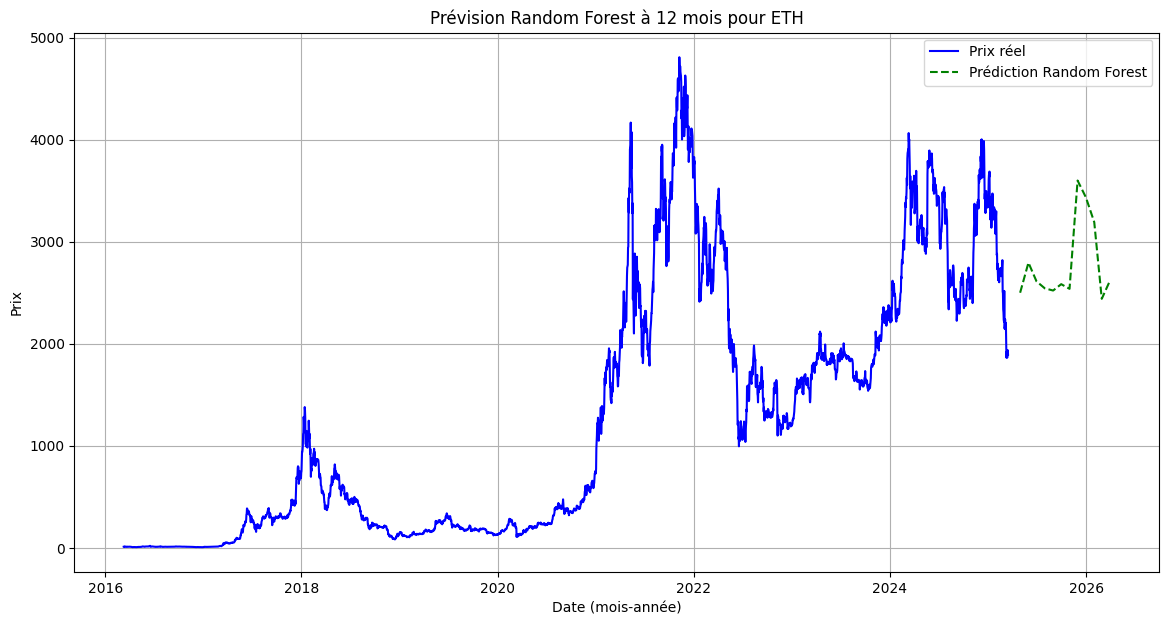

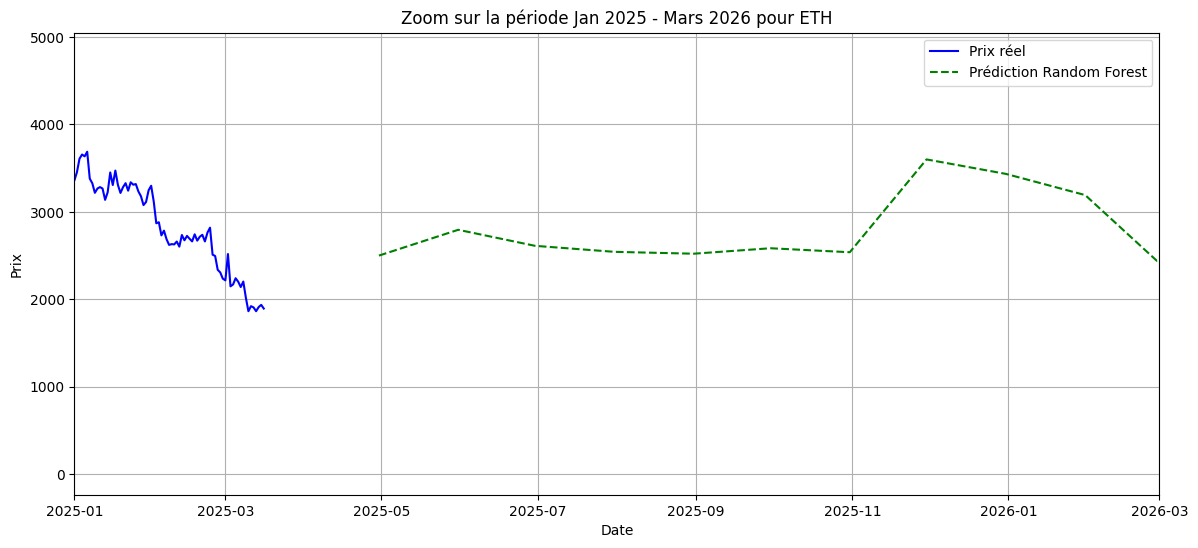

Crypto: ETH | MSE: 883.87


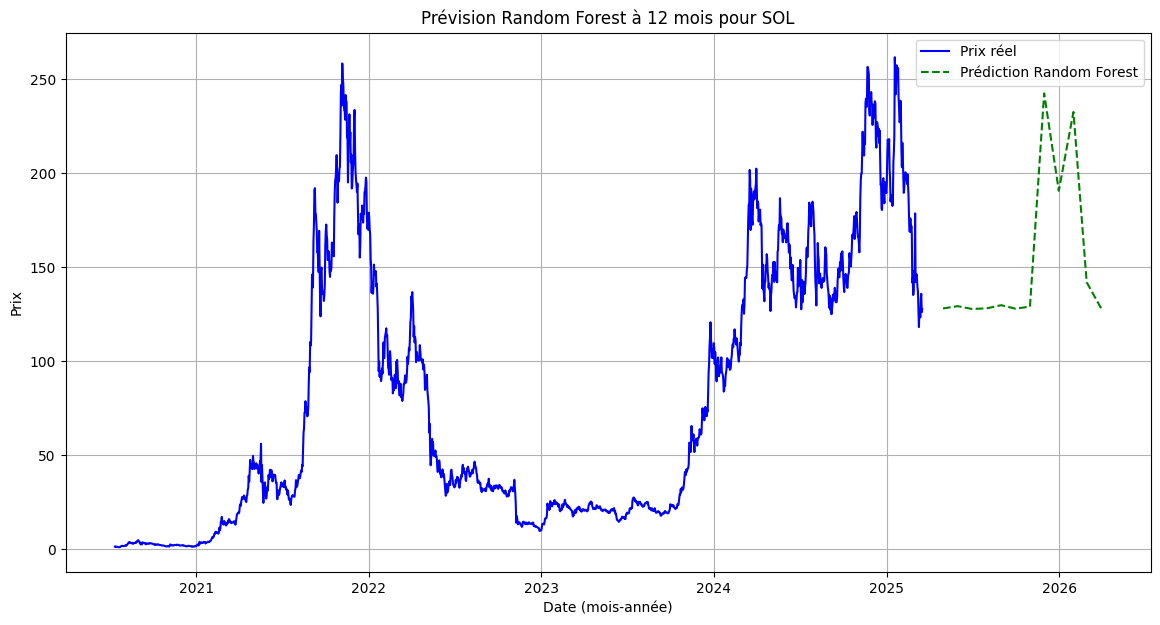

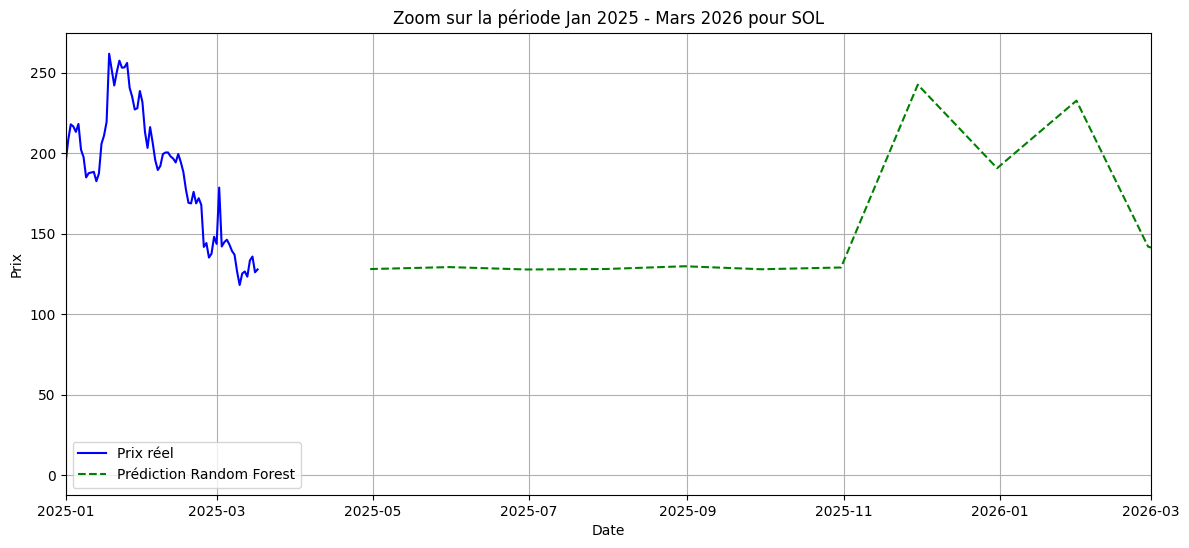

Crypto: SOL | MSE: 3.88


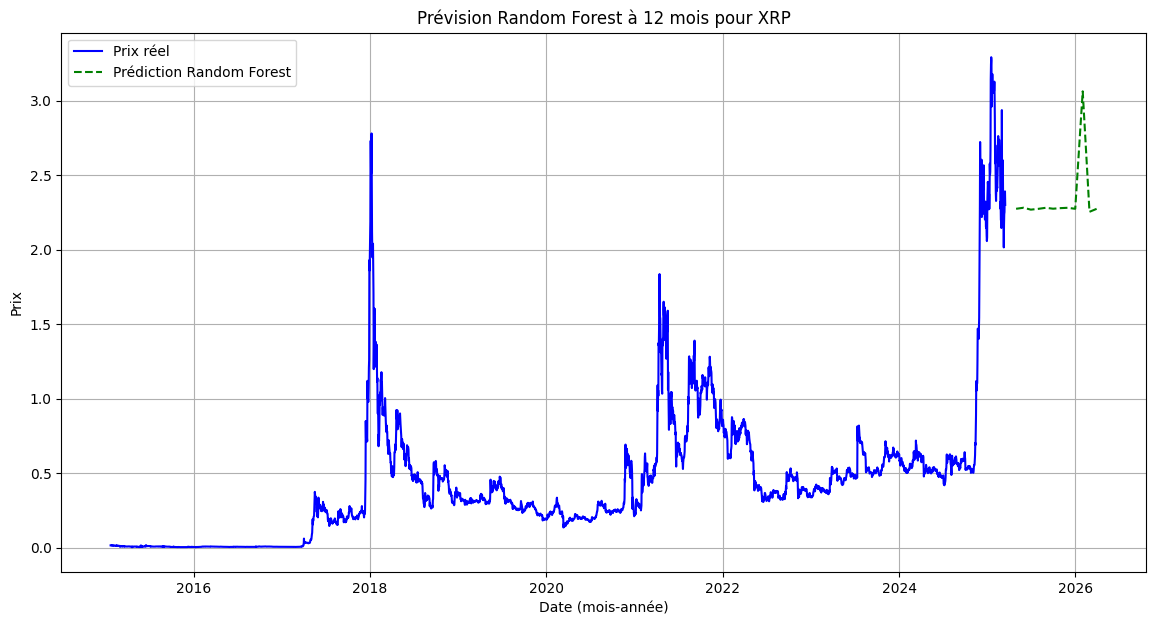

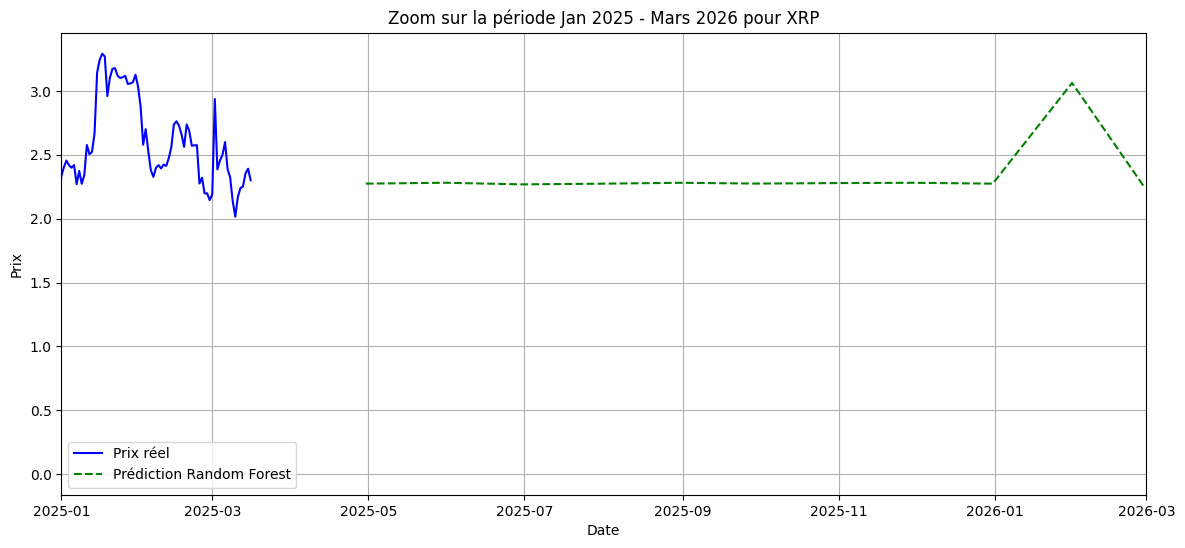

Crypto: XRP | MSE: 0.00


In [170]:
mse_rf = {}

for crypto in cryptos:
    df = crypto_df[crypto_df['Crypto'] == crypto].copy()

    # caractéristiques temporelles + volume
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Weekday'] = df['Date'].dt.weekday
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    features = ['Vol.', 'Year', 'Month', 'Day', 'Weekday', 'Quarter', 'DayOfYear']
    
    # Entrainement du modèle
    rf = RandomForestRegressor(n_estimators=1000, max_depth=20, min_samples_split=3, min_samples_leaf=1, random_state=42)
    rf.fit(df[features], df['Price'])
    
    # Générer des dates futures pour 12 mois supplémentaires
    future_dates = pd.date_range(start=df['Date'].max(), periods=13, freq='ME')[1:]
    future_df = pd.DataFrame({'Date': future_dates})
    
    # Ajout des caractéristiques temporelles aux données futures
    future_df['Year'] = future_df['Date'].dt.year
    future_df['Month'] = future_df['Date'].dt.month
    future_df['Day'] = future_df['Date'].dt.day
    future_df['Weekday'] = future_df['Date'].dt.weekday
    future_df['Quarter'] = future_df['Date'].dt.quarter
    future_df['DayOfYear'] = future_df['Date'].dt.dayofyear
    future_df['Vol.'] = df['Vol.'].median()
    
    # Prédiction
    future_predictions = rf.predict(future_df[features])
    
    # Affichage amélioré
    plt.figure(figsize=(14,7))
    plt.plot(df['Date'], df['Price'], label='Prix réel', color='blue')
    plt.plot(future_dates, future_predictions, label='Prédiction Random Forest', color='green', linestyle='dashed')
    plt.title(f'Prévision Random Forest à 12 mois pour {crypto}')
    plt.xlabel('Date (mois-année)')
    plt.ylabel('Prix')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Zoom sur la période Jan 2025 - Mars 2026
    plt.figure(figsize=(14,6))
    plt.plot(df['Date'], df['Price'], label='Prix réel', color='blue')
    plt.plot(future_dates, future_predictions, label='Prédiction Random Forest', color='green', linestyle='dashed')
    plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2026-03-01'))
    plt.title(f'Zoom sur la période Jan 2025 - Mars 2026 pour {crypto}')
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Évaluation avec MSE
    mse = mean_squared_error(df['Price'], rf.predict(df[features]))
    mse_rf[crypto] = mse
    print(f'Crypto: {crypto} | MSE: {mse:.2f}')

#### Comparaison des MSE entre Random Forest et Prophet pour chaque crypto séparément

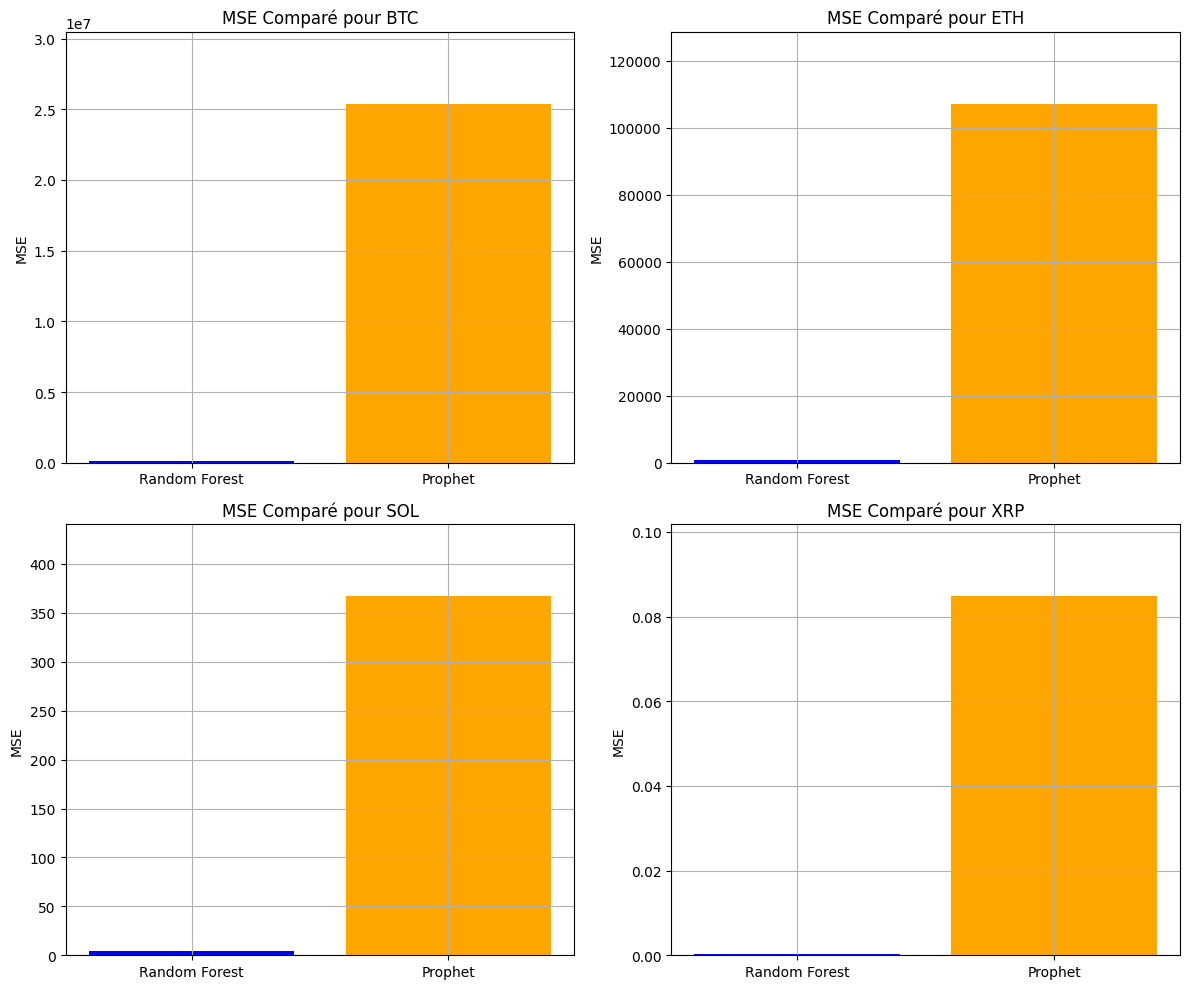

In [174]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i, crypto in enumerate(cryptos):
    axes[i].bar(['Random Forest', 'Prophet'], [mse_rf[crypto], mse_prophet[crypto]], color=['blue', 'orange'])
    axes[i].set_title(f'MSE Comparé pour {crypto}')
    axes[i].set_ylabel('MSE')
    axes[i].grid(True)
    axes[i].set_ylim(0, max(mse_rf[crypto], mse_prophet[crypto]) * 1.2)  # Ajustement de l'échelle

plt.tight_layout()
plt.show()
